# KNN Classification dengan LBP Features + Optuna Tuning (OPTIMIZED)
**Optimasi:**
- IMG_SIZE dikurangi dari 224 → 128 untuk performa lebih cepat
- Error handling untuk gambar corrupt
- Multi-region LBP untuk fitur lebih rich tanpa menambah waktu terlalu banyak

In [78]:
import os
import json
import time
import warnings
import numpy as np
import pandas as pd
import cv2
import joblib
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, top_k_accuracy_score

try:
    from skimage.feature import local_binary_pattern
    SKIMAGE_AVAILABLE = True
    print('✓ skimage tersedia')
except ImportError:
    SKIMAGE_AVAILABLE = False
    print('⚠ skimage tidak tersedia, menggunakan fallback LBP')

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

✓ skimage tersedia


In [79]:
class Config:
    TRAIN_DIR = '/kaggle/input/biji-kopi/train'
    VAL_DIR = '/kaggle/input/biji-kopi/valid'
    TEST_DIR = '/kaggle/input/biji-kopi/test'
    
    # OPTIMASI: Reduce IMG_SIZE untuk performa lebih cepat
    IMG_SIZE = 128  # Dari 224 → 128 (4x lebih cepat!)
    
    LBP_RADIUS = 2
    LBP_POINTS = 16
    OPTUNA_TRIALS = 50
    RANDOM_STATE = 42
    OUTPUT_DIR = './output_knn_lbp_optuna'
    NUM_CLASSES = 54

os.makedirs(Config.OUTPUT_DIR, exist_ok=True)
print(f'✓ Config siap: IMG_SIZE={Config.IMG_SIZE}, LBP_RADIUS={Config.LBP_RADIUS}, LBP_POINTS={Config.LBP_POINTS}')

✓ Config siap: IMG_SIZE=128, LBP_RADIUS=2, LBP_POINTS=16


In [80]:
class FeatureExtractorLBP:
    """Ekstraksi fitur LBP dengan multi-region untuk fitur lebih rich"""
    
    def __init__(self, img_size=128, radius=2, n_points=16, use_multiregion=True):
        self.img_size = img_size
        self.radius = radius
        self.n_points = n_points
        self.n_bins = n_points + 2
        self.use_multiregion = use_multiregion
    
    def compute_lbp(self, image_gray):
        """Compute LBP histogram dari grayscale image"""
        if SKIMAGE_AVAILABLE:
            lbp = local_binary_pattern(image_gray, self.n_points, self.radius, method='uniform')
            hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, self.n_bins + 1), 
                                   range=(0, self.n_bins))
        else:
            # Fallback: simple 8-point LBP
            lbp_image = self._manual_lbp(image_gray)
            hist, _ = np.histogram(lbp_image.ravel(), bins=256, range=(0, 256))
        
        # Normalize histogram
        hist = hist.astype('float')
        hist /= (hist.sum() + 1e-7)
        return hist
    
    def _manual_lbp(self, image_gray):
        """Fallback manual LBP 8-point"""
        h, w = image_gray.shape
        lbp_image = np.zeros_like(image_gray, dtype=np.uint8)
        
        for i in range(1, h-1):
            for j in range(1, w-1):
                center = image_gray[i, j]
                code = 0
                code |= (image_gray[i-1, j-1] >= center) << 7
                code |= (image_gray[i-1, j] >= center) << 6
                code |= (image_gray[i-1, j+1] >= center) << 5
                code |= (image_gray[i, j+1] >= center) << 4
                code |= (image_gray[i+1, j+1] >= center) << 3
                code |= (image_gray[i+1, j] >= center) << 2
                code |= (image_gray[i+1, j-1] >= center) << 1
                code |= (image_gray[i, j-1] >= center) << 0
                lbp_image[i, j] = code
        
        return lbp_image
    
    def extract_multiregion(self, img_gray):
        """Ekstrak LBP dari 4 region (top-left, top-right, bottom-left, bottom-right)"""
        h, w = img_gray.shape
        h2, w2 = h // 2, w // 2
        
        regions = [
            img_gray[0:h2, 0:w2],      # top-left
            img_gray[0:h2, w2:w],      # top-right
            img_gray[h2:h, 0:w2],      # bottom-left
            img_gray[h2:h, w2:w]       # bottom-right
        ]
        
        # Compute LBP untuk setiap region dan concat
        features = []
        for region in regions:
            hist = self.compute_lbp(region)
            features.append(hist)
        
        # Concat semua region features
        return np.concatenate(features)
    
    def extract(self, image_path):
        """Ekstrak fitur LBP dari image path"""
        try:
            # Baca dan resize
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                raise ValueError(f"Cannot read image: {image_path}")
            
            img = cv2.resize(img, (self.img_size, self.img_size))
            
            # Ekstrak fitur
            if self.use_multiregion:
                feature = self.extract_multiregion(img)
            else:
                feature = self.compute_lbp(img)
            
            return feature
        
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            # Return zero feature jika error
            if self.use_multiregion:
                return np.zeros(self.n_bins * 4)
            else:
                return np.zeros(self.n_bins)
    
    def extract_from_directory(self, directory):
        """Ekstrak fitur dari semua gambar di directory"""
        features = []
        labels = []
        class_names = sorted([d for d in os.listdir(directory) 
                             if os.path.isdir(os.path.join(directory, d))])
        
        for class_name in tqdm(class_names, desc='Ekstraksi kelas'):
            class_path = os.path.join(directory, class_name)
            
            image_files = [f for f in os.listdir(class_path) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            
            for img_file in tqdm(image_files, desc=f'{class_name}', leave=False):
                img_path = os.path.join(class_path, img_file)
                feature = self.extract(img_path)
                
                # Skip jika zero feature (error)
                if not np.all(feature == 0):
                    features.append(feature)
                    labels.append(class_name)
        
        return np.array(features), np.array(labels), class_names

print('✓ FeatureExtractorLBP class siap')

✓ FeatureExtractorLBP class siap


In [81]:
print('='*60)
print('MULAI EKSTRAKSI FITUR LBP')
print('='*60)

extractor = FeatureExtractorLBP(
    img_size=Config.IMG_SIZE, 
    radius=Config.LBP_RADIUS, 
    n_points=Config.LBP_POINTS,
    use_multiregion=True  # 4 regions untuk fitur lebih rich
)

start_time = time.time()

print('\n[1/3] Ekstraksi fitur TRAIN...')
X_train, y_train, class_names = extractor.extract_from_directory(Config.TRAIN_DIR)

print('[2/3] Ekstraksi fitur VALIDATION...')
X_val, y_val, _ = extractor.extract_from_directory(Config.VAL_DIR)

print('[3/3] Ekstraksi fitur TEST...')
X_test, y_test, _ = extractor.extract_from_directory(Config.TEST_DIR)

extraction_time = time.time() - start_time

# Encode labels
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print('\n' + '='*60)
print('RINGKASAN EKSTRAKSI FITUR')
print('='*60)
print(f'Waktu ekstraksi: {extraction_time:.1f} detik ({extraction_time/60:.1f} menit)')
print(f'Train: {len(X_train_scaled)} samples')
print(f'Valid: {len(X_val_scaled)} samples')
print(f'Test:  {len(X_test_scaled)} samples')
print(f'Dimensi fitur: {X_train_scaled.shape[1]}')
print(f'Jumlah kelas: {len(label_encoder.classes_)}')
print('='*60)

MULAI EKSTRAKSI FITUR LBP

[1/3] Ekstraksi fitur TRAIN...


Ekstraksi kelas:   0%|          | 0/54 [00:00<?, ?it/s]

Arabika Aceh Gayo:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Argo Puro:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Arjuno Budug Asu:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Bali Batu Karu:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Bali Kintamani:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Bali Ulian:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Dolok Sanggul:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Enrekang:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Flores Bajawa:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Flores Manggarai:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Golosera Wae Rebo:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Ijen:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Java Ciwidey:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Java Garut:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Java Puntang:   0%|          | 0/120 [00:00<?, ?it/s]

Arabika Java Temanggung:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Kerinci Kayu Aro:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Latimojong:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Lintong:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Lintong Onan Ganjang:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Malabar Mountain:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Mandailing:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Mangalayang:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Papua Lembah Kamu:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Papua Moanemani:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Papua Yahukimo:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Semendo:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Simalungun:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Sindoro:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Sipirok:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Solok Radjo:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Sulawesi Karangan Angin:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Surambu Pulu Pulu:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Tanah Karo:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Tolu Batak:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Toraja:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Toraja Bolokan:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Wamena:   0%|          | 0/134 [00:00<?, ?it/s]

Arabika Wanoja Kamojang:   0%|          | 0/134 [00:00<?, ?it/s]

Liberika Lampung:   0%|          | 0/134 [00:00<?, ?it/s]

Liberika Sumedang:   0%|          | 0/134 [00:00<?, ?it/s]

Liberika Temanggung:   0%|          | 0/134 [00:00<?, ?it/s]

Robusta Bali:   0%|          | 0/134 [00:00<?, ?it/s]

Robusta Bali Pupuan:   0%|          | 0/134 [00:00<?, ?it/s]

Robusta Dampit:   0%|          | 0/134 [00:00<?, ?it/s]

Robusta Flores Manggarai:   0%|          | 0/134 [00:00<?, ?it/s]

Robusta Gayo:   0%|          | 0/134 [00:00<?, ?it/s]

Robusta Java GKawi:   0%|          | 0/134 [00:00<?, ?it/s]

Robusta Lampung:   0%|          | 0/134 [00:00<?, ?it/s]

Robusta Pagar Alam:   0%|          | 0/148 [00:00<?, ?it/s]

Robusta Pinogu:   0%|          | 0/134 [00:00<?, ?it/s]

Robusta Semeru:   0%|          | 0/134 [00:00<?, ?it/s]

Robusta Sidikalang:   0%|          | 0/134 [00:00<?, ?it/s]

Robusta Temanggung:   0%|          | 0/134 [00:00<?, ?it/s]

[2/3] Ekstraksi fitur VALIDATION...


Ekstraksi kelas:   0%|          | 0/54 [00:00<?, ?it/s]

Arabika Aceh Gayo:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Argo Puro:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Arjuno Budug Asu:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Bali Batu Karu:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Bali Kintamani:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Bali Ulian:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Dolok Sanggul:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Enrekang:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Flores Bajawa:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Flores Manggarai:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Golosera Wae Rebo:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Ijen:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Java Ciwidey:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Java Garut:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Java Puntang:   0%|          | 0/16 [00:00<?, ?it/s]

Arabika Java Temanggung:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Kerinci Kayu Aro:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Latimojong:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Lintong:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Lintong Onan Ganjang:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Malabar Mountain:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Mandailing:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Mangalayang:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Papua Lembah Kamu:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Papua Moanemani:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Papua Yahukimo:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Semendo:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Simalungun:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Sindoro:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Sipirok:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Solok Radjo:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Sulawesi Karangan Angin:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Surambu Pulu Pulu:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Tanah Karo:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Tolu Batak:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Toraja:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Toraja Bolokan:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Wamena:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Wanoja Kamojang:   0%|          | 0/17 [00:00<?, ?it/s]

Liberika Lampung:   0%|          | 0/17 [00:00<?, ?it/s]

Liberika Sumedang:   0%|          | 0/17 [00:00<?, ?it/s]

Liberika Temanggung:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Bali:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Bali Pupuan:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Dampit:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Flores Manggarai:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Gayo:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Java GKawi:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Lampung:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Pagar Alam:   0%|          | 0/18 [00:00<?, ?it/s]

Robusta Pinogu:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Semeru:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Sidikalang:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Temanggung:   0%|          | 0/17 [00:00<?, ?it/s]

[3/3] Ekstraksi fitur TEST...


Ekstraksi kelas:   0%|          | 0/54 [00:00<?, ?it/s]

Arabika Aceh Gayo:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Argo Puro:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Arjuno Budug Asu:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Bali Batu Karu:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Bali Kintamani:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Bali Ulian:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Dolok Sanggul:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Enrekang:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Flores Bajawa:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Flores Manggarai:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Golosera Wae Rebo:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Ijen:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Java Ciwidey:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Java Garut:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Java Puntang:   0%|          | 0/13 [00:00<?, ?it/s]

Arabika Java Temanggung:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Kerinci Kayu Aro:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Latimojong:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Lintong:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Lintong Onan Ganjang:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Malabar Mountain:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Mandailing:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Mangalayang:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Papua Lembah Kamu:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Papua Moanemani:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Papua Yahukimo:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Semendo:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Simalungun:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Sindoro:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Sipirok:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Solok Radjo:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Sulawesi Karangan Angin:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Surambu Pulu Pulu:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Tanah Karo:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Tolu Batak:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Toraja:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Toraja Bolokan:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Wamena:   0%|          | 0/17 [00:00<?, ?it/s]

Arabika Wanoja Kamojang:   0%|          | 0/17 [00:00<?, ?it/s]

Liberika Lampung:   0%|          | 0/17 [00:00<?, ?it/s]

Liberika Sumedang:   0%|          | 0/17 [00:00<?, ?it/s]

Liberika Temanggung:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Bali:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Bali Pupuan:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Dampit:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Flores Manggarai:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Gayo:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Java GKawi:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Lampung:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Pagar Alam:   0%|          | 0/21 [00:00<?, ?it/s]

Robusta Pinogu:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Semeru:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Sidikalang:   0%|          | 0/17 [00:00<?, ?it/s]

Robusta Temanggung:   0%|          | 0/17 [00:00<?, ?it/s]


RINGKASAN EKSTRAKSI FITUR
Waktu ekstraksi: 76.7 detik (1.3 menit)
Train: 7236 samples
Valid: 918 samples
Test:  918 samples
Dimensi fitur: 72
Jumlah kelas: 54


In [82]:
def objective(trial):
    """Optuna objective untuk KNN"""
    n_neighbors = trial.suggest_int('n_neighbors', 3, 25)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'chebyshev'])
    
    model = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        metric=metric,
        n_jobs=-1
    )
    
    model.fit(X_train_scaled, y_train_enc)
    y_pred_val = model.predict(X_val_scaled)
    accuracy = accuracy_score(y_val_enc, y_pred_val)
    
    return accuracy

print('✓ Optuna objective function siap')

✓ Optuna objective function siap


In [83]:
print('='*60)
print(f'OPTUNA HYPERPARAMETER TUNING ({Config.OPTUNA_TRIALS} trials)')
print('='*60)

study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=Config.RANDOM_STATE)
)

study.optimize(objective, n_trials=Config.OPTUNA_TRIALS, show_progress_bar=True)

print('\n' + '='*60)
print('HASIL OPTUNA')
print('='*60)
print(f'Best validation accuracy: {study.best_value:.4f} ({study.best_value*100:.2f}%)')
print('\nBest hyperparameters:')
for key, value in study.best_params.items():
    print(f'  {key}: {value}')
print('='*60)

OPTUNA HYPERPARAMETER TUNING (50 trials)


  0%|          | 0/50 [00:00<?, ?it/s]


HASIL OPTUNA
Best validation accuracy: 0.2092 (20.92%)

Best hyperparameters:
  n_neighbors: 19
  weights: distance
  metric: manhattan


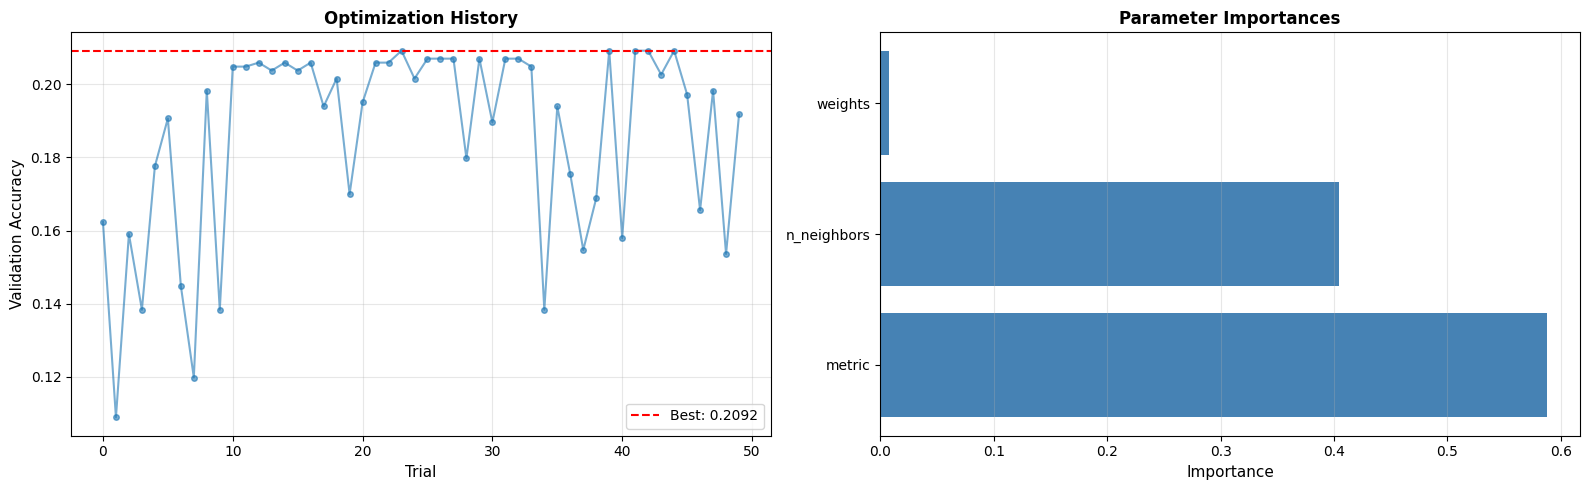

✓ Plot disimpan ke ./output_knn_lbp_optuna/optuna_plots.png


In [84]:
# Visualisasi Optuna
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Optimization history
trials_df = study.trials_dataframe()
axes[0].plot(trials_df['number'], trials_df['value'], marker='o', markersize=4, alpha=0.6)
axes[0].axhline(y=study.best_value, color='r', linestyle='--', 
                label=f'Best: {study.best_value:.4f}')
axes[0].set_xlabel('Trial', fontsize=11)
axes[0].set_ylabel('Validation Accuracy', fontsize=11)
axes[0].set_title('Optimization History', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Parameter importances
try:
    importances = optuna.importance.get_param_importances(study)
    params = list(importances.keys())
    values = list(importances.values())
    
    axes[1].barh(params, values, color='steelblue')
    axes[1].set_xlabel('Importance', fontsize=11)
    axes[1].set_title('Parameter Importances', fontsize=12, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='x')
except:
    axes[1].text(0.5, 0.5, 'Parameter importance\ntidak tersedia', 
                 ha='center', va='center', transform=axes[1].transAxes, fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(Config.OUTPUT_DIR, 'optuna_plots.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f'✓ Plot disimpan ke {Config.OUTPUT_DIR}/optuna_plots.png')

In [85]:
print('Training model final dengan best params...')

best_params = study.best_params
final_model = KNeighborsClassifier(
    n_neighbors=best_params['n_neighbors'],
    weights=best_params['weights'],
    metric=best_params['metric'],
    n_jobs=-1
)

final_model.fit(X_train_scaled, y_train_enc)

# Simpan model dan preprocessor
joblib.dump(final_model, os.path.join(Config.OUTPUT_DIR, 'knn_model_lbp_optuna.pkl'))
joblib.dump(scaler, os.path.join(Config.OUTPUT_DIR, 'scaler_lbp_optuna.pkl'))
joblib.dump(label_encoder, os.path.join(Config.OUTPUT_DIR, 'label_encoder_lbp_optuna.pkl'))

print('✓ Model final dengan best params berhasil dilatih dan disimpan.')

Training model final dengan best params...
✓ Model final dengan best params berhasil dilatih dan disimpan.


In [86]:
print('='*60)
print('EVALUASI TEST SET')
print('='*60)

y_pred = final_model.predict(X_test_scaled)
y_proba = final_model.predict_proba(X_test_scaled)

top1_accuracy = accuracy_score(y_test_enc, y_pred)
top5_accuracy = top_k_accuracy_score(y_test_enc, y_proba, k=5)
macro_f1 = f1_score(y_test_enc, y_pred, average='macro')

print(f'\nTop-1 Accuracy: {top1_accuracy:.4f} ({top1_accuracy*100:.2f}%)')
print(f'Top-5 Accuracy: {top5_accuracy:.4f} ({top5_accuracy*100:.2f}%)')
print(f'Macro F1-Score: {macro_f1:.4f}')
print('\n--- Classification Report ---')
print(classification_report(y_test_enc, y_pred, target_names=label_encoder.classes_, digits=4))

EVALUASI TEST SET

Top-1 Accuracy: 0.2037 (20.37%)
Top-5 Accuracy: 0.4913 (49.13%)
Macro F1-Score: 0.1894

--- Classification Report ---
                                 precision    recall  f1-score   support

              Arabika Aceh Gayo     0.1111    0.1176    0.1143        17
              Arabika Argo Puro     0.1176    0.1176    0.1176        17
       Arabika Arjuno Budug Asu     0.3182    0.4118    0.3590        17
         Arabika Bali Batu Karu     0.2000    0.0588    0.0909        17
         Arabika Bali Kintamani     0.2083    0.2941    0.2439        17
             Arabika Bali Ulian     0.0500    0.0588    0.0541        17
          Arabika Dolok Sanggul     0.2174    0.2941    0.2500        17
               Arabika Enrekang     0.0000    0.0000    0.0000        17
          Arabika Flores Bajawa     0.2273    0.5882    0.3279        17
       Arabika Flores Manggarai     0.1429    0.0588    0.0833        17
      Arabika Golosera Wae Rebo     0.2000    0.2353    0.2

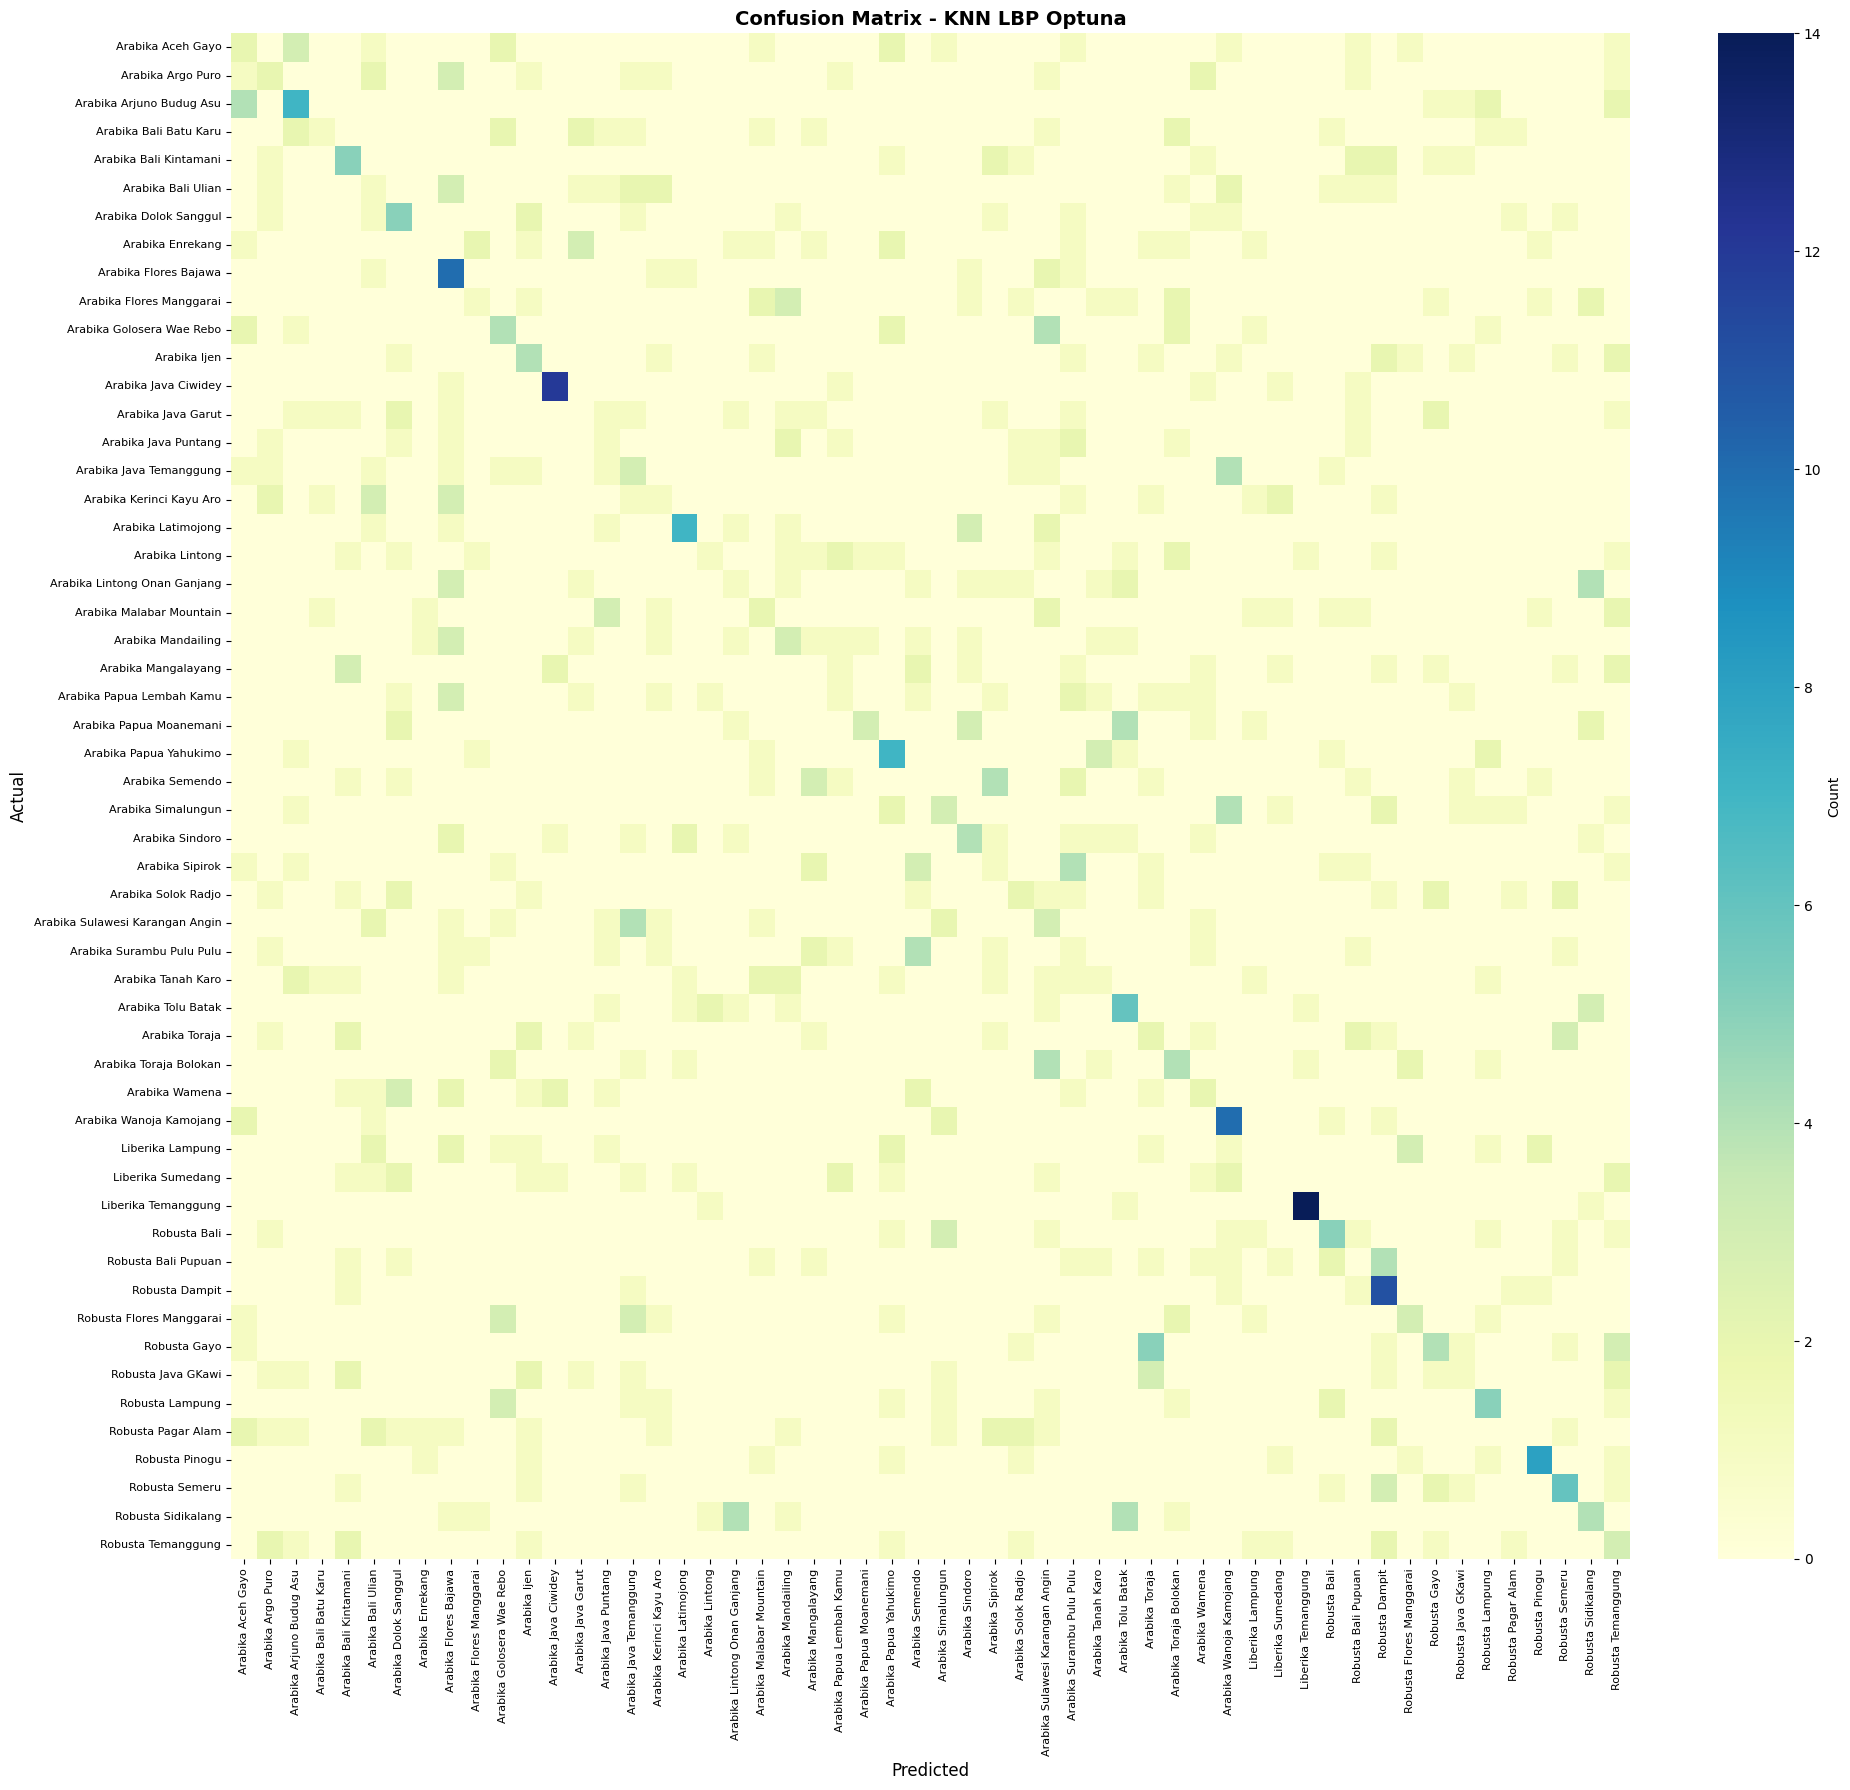

✓ Confusion matrix saved to ./output_knn_lbp_optuna/confusion_matrix_lbp.png


In [87]:
# Confusion matrix
cm = confusion_matrix(y_test_enc, y_pred)

plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=False, fmt='d', cmap='YlGnBu', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix - KNN LBP Optuna', fontsize=14, fontweight='bold')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(Config.OUTPUT_DIR, 'confusion_matrix_lbp.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f'✓ Confusion matrix saved to {Config.OUTPUT_DIR}/confusion_matrix_lbp.png')

In [88]:
# Per-class accuracy
per_class_acc = []
for i, class_name in enumerate(label_encoder.classes_):
    mask = y_test_enc == i
    total = mask.sum()
    if total > 0:
        correct = (y_pred[mask] == i).sum()
        acc = correct / total
        per_class_acc.append({
            'Class': class_name,
            'Accuracy': acc,
            'Samples': total
        })

df_per_class = pd.DataFrame(per_class_acc)
df_per_class = df_per_class.sort_values('Accuracy', ascending=False)
df_per_class.to_csv(os.path.join(Config.OUTPUT_DIR, 'per_class_lbp.csv'), index=False)

print('='*60)
print('PER-CLASS ACCURACY (Top 10 & Bottom 10)')
print('='*60)
print('\nTop 10:')
print(df_per_class.head(10).to_string(index=False))
print('\nBottom 10:')
print(df_per_class.tail(10).to_string(index=False))
print(f'\n✓ Full results saved to {Config.OUTPUT_DIR}/per_class_lbp.csv')

PER-CLASS ACCURACY (Top 10 & Bottom 10)

Top 10:
                   Class  Accuracy  Samples
     Liberika Temanggung  0.823529       17
    Arabika Java Ciwidey  0.705882       17
          Robusta Dampit  0.647059       17
 Arabika Wanoja Kamojang  0.588235       17
   Arabika Flores Bajawa  0.588235       17
          Robusta Pinogu  0.470588       17
Arabika Arjuno Budug Asu  0.411765       17
      Arabika Latimojong  0.411765       17
  Arabika Papua Yahukimo  0.411765       17
      Arabika Tolu Batak  0.352941       17

Bottom 10:
              Class  Accuracy  Samples
    Arabika Sipirok  0.058824       17
 Arabika Tanah Karo  0.058824       17
   Arabika Enrekang  0.000000       17
 Arabika Java Garut  0.000000       17
Arabika Mangalayang  0.000000       17
    Arabika Semendo  0.000000       17
Robusta Bali Pupuan  0.000000       17
  Liberika Sumedang  0.000000       17
   Liberika Lampung  0.000000       17
 Robusta Pagar Alam  0.000000       21

✓ Full results saved to .

In [89]:
# Final results JSON
final_results = {
    'model': 'KNN_LBP_Optuna',
    'num_classes': Config.NUM_CLASSES,
    'feature_dim': int(X_train.shape[1]),
    'config': {
        'img_size': Config.IMG_SIZE,
        'lbp_radius': Config.LBP_RADIUS,
        'lbp_points': Config.LBP_POINTS,
        'multiregion': True
    },
    'optuna_trials': Config.OPTUNA_TRIALS,
    'best_params': study.best_params,
    'best_val_accuracy': float(study.best_value),
    'metrics': {
        'top1_accuracy': float(top1_accuracy),
        'top5_accuracy': float(top5_accuracy),
        'macro_f1': float(macro_f1)
    },
    'dataset': {
        'train_samples': int(len(y_train)),
        'val_samples': int(len(y_val)),
        'test_samples': int(len(y_test))
    },
    'extraction_time_seconds': float(extraction_time)
}

results_path = os.path.join(Config.OUTPUT_DIR, 'final_results_lbp.json')
with open(results_path, 'w') as f:
    json.dump(final_results, f, indent=2)

print('='*60)
print('FINAL RESULTS')
print('='*60)
print(json.dumps(final_results, indent=2))
print(f'\n✓ Hasil final disimpan ke: {results_path}')
print('\n' + '='*60)
print('SEMUA PROSES SELESAI!')
print('='*60)

FINAL RESULTS
{
  "model": "KNN_LBP_Optuna",
  "num_classes": 54,
  "feature_dim": 72,
  "config": {
    "img_size": 128,
    "lbp_radius": 2,
    "lbp_points": 16,
    "multiregion": true
  },
  "optuna_trials": 50,
  "best_params": {
    "n_neighbors": 19,
    "weights": "distance",
    "metric": "manhattan"
  },
  "best_val_accuracy": 0.20915032679738563,
  "metrics": {
    "top1_accuracy": 0.2037037037037037,
    "top5_accuracy": 0.4912854030501089,
    "macro_f1": 0.18938423131305107
  },
  "dataset": {
    "train_samples": 7236,
    "val_samples": 918,
    "test_samples": 918
  },
  "extraction_time_seconds": 76.74530696868896
}

✓ Hasil final disimpan ke: ./output_knn_lbp_optuna/final_results_lbp.json

SEMUA PROSES SELESAI!
